# Prediction Euro 2024 with XGBoost


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

---

_**Using Gradient Boosted Trees to Predict Football team score**_

---

---

## Runtime

This notebook takes approximately 8 minutes to run.

## Contents

1. Loading Libraries
2. Loading the Dataset
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Model Building
6. Cross-Validation
7. Model Evaluation
8. Conclusion

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_


This notebook demonstrates the use of XGBoost to predict match results for the Euro dataset. We will walk through the data loading, preprocessing, model training, and evaluation steps.

Predicting the outcomes of football matches can provide valuable insights for teams, coaches, and analysts. By analyzing past match data, we can forecast future match results, aiding in strategic planning and decision-making. This notebook describes using machine learning (ML) to predict the score of football matches, specifically focusing on the Euro 2024 tournament.

We use historical data from past matches to build a model that can predict the score of a current match based on various features, including team formations, player statistics, and previous match outcomes. Accurate predictions can help teams optimize their strategies, identify strengths and weaknesses, and potentially gain a competitive edge. In this notebook, we will also address how to incorporate various features and metrics specific to football matches to improve the model's accuracy.

---

## Setup

_This notebook was created and tested on a `ml.m4.xlarge` notebook instance._

Let's start by updating the required packages i.e. SageMaker Python SDK, `pandas` and `numpy`, and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance or Studio, training, and hosting.
- The IAM role ARN used to give training and hosting access to your data. See the documentation for how to create these.  Note: if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with the appropriate full IAM role ARN string(s).

In [66]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
!pip3 install -U sagemaker

  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)


In [67]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-score"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the example.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import matplotlib.pyplot as plt
import seaborn as sns

---
## Data

Football teams have historical records of match outcomes, player statistics, team formations, and other relevant metrics. We can use this historical information to construct an ML model to predict the score of a current match using a process called training. After training the model, we can input the details of an upcoming match (using the same type of data that we used to train the model), and have the model predict the expected score. Naturally, we expect the model to make some errors, as predicting match outcomes can be quite complex. However, we will learn how to handle and interpret these prediction errors.

The dataset we use includes historical data on Euro 2024 teams from various leagues, containing information such as team formations, player statistics, match outcomes, and other relevant features. This data will allow us to build a robust model to predict match scores.

Let's download and read this dataset now:

In [69]:
import sagemaker
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket() 
key_prefix = f"data_science_club_tau/fixtures_merged_statistics_df.csv"

In [70]:
s3 = boto3.client("s3")
s3.download_file(bucket,key_prefix,"fixtures_merged_statistics_df.csv")

In [71]:
# Load data
fixtures = pd.read_csv("./fixtures_merged_statistics_df.csv")
pd.set_option("display.max_columns", 500)

## Exploratory Data Analysis (EDA)
In this section, we'll perform exploratory data analysis to understand the dataset better.

In [72]:
len(fixtures.columns)

51

In [73]:
fixtures.columns

Index(['fixture_id', 'home_articipant', 'away_articipant', 'start_date',
       'leagueName', 'home_team_formation', 'away_team_formation',
       'home_yellow_cards', 'home_red_cards', 'away_yellow_cards',
       'away_red_cards', 'home_score', 'away_score', 'home_score_half_time',
       'away_score_half_time', 'home_score_conceded', 'away_score_conceded',
       'time_to_first_goal', 'time_to_first_goal_home_team',
       'time_to_first_goal_away_team', 'first_team_to_score',
       'first_team_to_score_is_home', 'first_team_to_score_is_away',
       'home_score_ratio', 'away_score_ratio', 'away_ball_possession',
       'away_corner_kicks', 'away_fouls', 'away_free_kicks', 'away_goal_kicks',
       'away_goalkeeper_saves', 'away_offsides', 'away_shots_off_target',
       'away_shots_on_target', 'away_throw_ins', 'away_total_shots',
       'home_ball_possession', 'home_corner_kicks', 'home_fouls',
       'home_free_kicks', 'home_goal_kicks', 'home_goalkeeper_saves',
       'home_offs

In [74]:
fixtures.head()

,fixture_id,home_articipant,away_articipant,start_date,leagueName,home_team_formation,away_team_formation,home_yellow_cards,home_red_cards,away_yellow_cards,away_red_cards,home_score,away_score,home_score_half_time,away_score_half_time,home_score_conceded,away_score_conceded,time_to_first_goal,time_to_first_goal_home_team,time_to_first_goal_away_team,first_team_to_score,first_team_to_score_is_home,first_team_to_score_is_away,home_score_ratio,away_score_ratio,away_ball_possession,away_corner_kicks,away_fouls,away_free_kicks,away_goal_kicks,away_goalkeeper_saves,away_offsides,away_shots_off_target,away_shots_on_target,away_throw_ins,away_total_shots,home_ball_possession,home_corner_kicks,home_fouls,home_free_kicks,home_goal_kicks,home_goalkeeper_saves,home_offsides,home_shots_off_target,home_shots_on_target,home_throw_ins,home_total_shots,total_offsides_dependent,total_red_cards_dependent,total_yellow_cards_dependent,total_corner_kicks_dependent
0,5076758,Greece,Romania,2014-09-07,european_championship,4|2|3|1,4|2|3|1,5.0,0.0,4.0,1.0,0,1,0,1,1,0,10,130,10,Away,0,1,0.000,0.000,36%,2.0,18.0,11.0,9.0,2.0,2.0,5.0,3.0,22.0,8.0,64%,3.0,11.0,18.0,8.0,2.0,2.0,5.0,2.0,31.0,11.0,4.0,1.0,9.0,5.0
1,5076974,Germany,Scotland,2014-09-07,european_championship,4|2|3|1,4|2|3|1,2.0,0.0,4.0,1.0,2,1,1,0,1,2,18,18,66,Home,1,0,1.000,1.000,35%,1.0,15.0,14.0,13.0,8.0,3.0,4.0,3.0,23.0,7.0,65%,12.0,13.0,18.0,4.0,2.0,1.0,11.0,11.0,19.0,22.0,4.0,1.0,6.0,13.0
2,5076624,Denmark,Armenia,2014-09-07,european_championship,5|3|2,5|3|2,1.0,0.0,1.0,0.0,2,1,0,0,1,2,50,65,50,Away,0,1,1.000,1.000,36%,2.0,12.0,15.0,15.0,4.0,2.0,2.0,2.0,15.0,4.0,64%,7.0,14.0,14.0,2.0,1.0,1.0,9.0,6.0,18.0,15.0,3.0,0.0,2.0,9.0
3,5076754,Hungary,Northern Ireland,2014-09-07,european_championship,4|2|3|1,4|2|3|1,1.0,0.0,1.0,0.0,1,2,0,0,2,1,75,75,81,Home,1,0,0.333,0.333,47%,2.0,18.0,13.0,10.0,5.0,1.0,4.0,4.0,21.0,8.0,53%,9.0,13.0,19.0,8.0,2.0,0.0,4.0,6.0,25.0,10.0,1.0,0.0,2.0,11.0
4,5076976,Gibraltar,Poland,2014-09-07,european_championship,NaN,NaN,1.0,0.0,2.0,0.0,0,7,0,1,7,0,11,130,11,Away,0,1,0.000,0.000,65%,9.0,9.0,11.0,6.0,1.0,1.0,9.0,16.0,30.0,25.0,35%,3.0,10.0,10.0,15.0,8.0,1.0,3.0,1.0,18.0,4.0,2.0,0.0,3.0,12.0


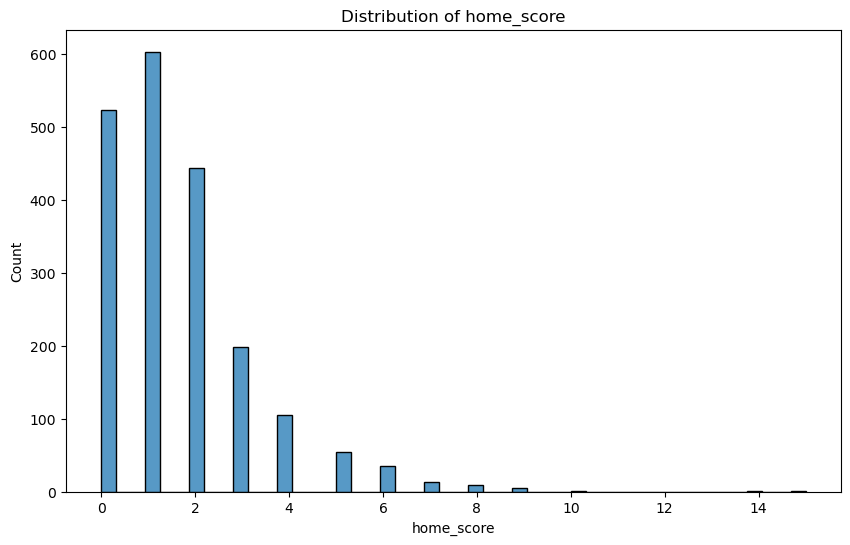

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of key features
plt.figure(figsize=(10, 6))
sns.histplot(fixtures['home_score'])
plt.title('Distribution of home_score')
plt.show()

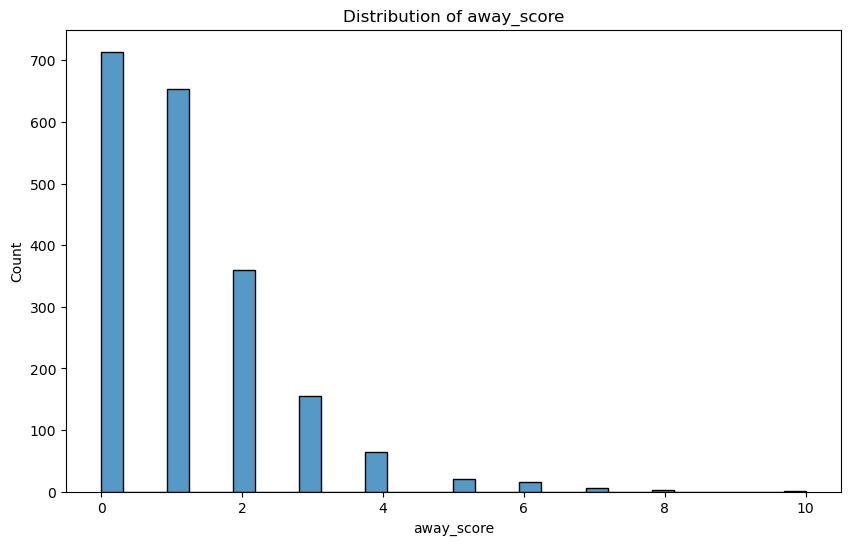

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of key features
plt.figure(figsize=(10, 6))
sns.histplot(fixtures['away_score'])
plt.title('Distribution of away_score')
plt.show()

In [77]:
# Summary statistics
fixtures.describe()

,fixture_id,home_yellow_cards,home_red_cards,away_yellow_cards,away_red_cards,home_score,away_score,home_score_half_time,away_score_half_time,home_score_conceded,away_score_conceded,time_to_first_goal,time_to_first_goal_home_team,time_to_first_goal_away_team,first_team_to_score_is_home,first_team_to_score_is_away,home_score_ratio,away_score_ratio,away_corner_kicks,away_fouls,away_free_kicks,away_goal_kicks,away_goalkeeper_saves,away_offsides,away_shots_off_target,away_shots_on_target,away_throw_ins,away_total_shots,home_corner_kicks,home_fouls,home_free_kicks,home_goal_kicks,home_goalkeeper_saves,home_offsides,home_shots_off_target,home_shots_on_target,home_throw_ins,home_total_shots,total_offsides_dependent,total_red_cards_dependent,total_yellow_cards_dependent,total_corner_kicks_dependent
count,1.991000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1791.000000,1826.000000,1826.000000,1878.000000
mean,8.501827e+06,1.686747,0.059693,1.968784,0.062432,1.622300,1.182320,0.729784,0.517328,1.182320,1.622300,37.866901,62.198393,72.438975,0.522351,0.405826,1.112663,1.112663,4.140043,12.138994,12.328286,8.636019,3.217580,1.806253,4.257127,3.787097,19.559459,9.855270,5.308839,12.009194,12.396431,7.188210,2.624525,1.953099,5.217859,4.831720,20.269730,12.233206,3.759352,0.122125,3.655531,9.448882
std,1.818234e+06,1.286563,0.252650,1.323180,0.248704,1.639029,1.287126,0.993098,0.778206,1.287126,1.639029,33.685418,46.020045,47.795441,0.499626,0.491175,1.461707,1.461707,2.902626,4.136685,4.463399,4.228846,2.275984,1.529919,2.672377,2.726130,6.343680,5.791583,3.341420,4.202970,4.394902,3.839481,2.088458,1.534348,3.099773,3.167065,6.507823,6.642610,2.065584,0.363971,1.972736,3.435267
min,5.075602e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.116421e+06,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,21.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,9.000000,5.000000,1.000000,1.000000,2.000000,2.000000,15.000000,6.000000,3.000000,9.000000,9.000000,4.000000,1.000000,1.000000,3.000000,3.000000,16.000000,8.000000,2.000000,0.000000,2.000000,7.000000
50%,8.079082e+06,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,28.000000,49.000000,62.000000,1.000000,0.000000,0.667000,0.667000,4.000000,12.000000,12.000000,8.000000,3.000000,2.000000,4.000000,3.000000,19.000000,9.000000,5.000000,12.000000,12.000000,7.000000,2.000000,2.000000,5.000000,4.000000,20.000000,11.000000,3.000000,0.000000,3.000000,9.000000
75%,1.002335e+07,2.000000,0.000000,3.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,52.000000,130.000000,130.000000,1.000000,1.000000,1.500000,1.500000,6.000000,15.000000,15.000000,11.000000,5.000000,3.000000,6.000000,5.000000,24.000000,13.000000,7.000000,15.000000,15.000000,9.000000,4.000000,3.000000,7.000000,7.000000,24.000000,16.000000,5.000000,0.000000,5.000000,12.000000
max,1.238325e+07,7.000000,2.000000,9.000000,2.000000,15.000000,10.000000,8.000000,6.000000,10.000000,15.000000,130.000000,130.000000,130.000000,1.000000,1.000000,14.000000,14.000000,19.000000,33.000000,32.000000,30.000000,14.000000,11.000000,16.000000,24.000000,48.000000,38.000000,22.000000,30.000000,32.000000,24.000000,15.00

In [78]:
# Check for missing values
fixtures.isnull().sum()

fixture_id                        0
home_articipant                   0
away_articipant                   0
start_date                        0
leagueName                        0
home_team_formation              57
away_team_formation              57
home_yellow_cards               165
home_red_cards                  165
away_yellow_cards               165
away_red_cards                  165
home_score                        0
away_score                        0
home_score_half_time              0
away_score_half_time              0
home_score_conceded               0
away_score_conceded               0
time_to_first_goal                0
time_to_first_goal_home_team      0
time_to_first_goal_away_team      0
first_team_to_score             143
first_team_to_score_is_home       0
first_team_to_score_is_away       0
home_score_ratio                  0
away_score_ratio                  0
away_ball_possession            153
away_corner_kicks               113
away_fouls                  

col_0,% observations
home_articipant,
Albania,0.024611
Andorra,0.007534
Argentina,0.002009
Armenia,0.007534
Australia,0.001005
...,...
Ukraine,0.025615
Uruguay,0.001507
Uzbekistan,0.000502


col_0,% observations
away_articipant,
Albania,0.022099
Algeria,0.000502
Andorra,0.008036
Argentina,0.003014
Armenia,0.010045
...,...
Ukraine,0.028127
United Arab Emirates,0.000502
Uruguay,0.003014


col_0,% observations
start_date,
2014-09-07,0.003516
2014-09-08,0.002511
2014-09-09,0.002009
2014-10-09,0.002511
2014-10-10,0.002511
...,...
2024-06-26,0.002009
2024-06-29,0.001005
2024-06-30,0.001005


col_0,% observations
leagueName,
club_friendly_games,0.002009
confederations_cup,0.005023
conmebol-uefa_cup_of_champions,0.000502
euro,0.022099
european_championship,0.269714
int._friendly_games,0.266198
king's_cup,0.001005
uefa_euro,0.049221
uefa_nations_league,0.142140


col_0,% observations
home_team_formation,
3|1|4|2,0.011375
3|3|1|3,0.000517
3|3|3|1,0.001034
3|4|1|2,0.027921
3|4|2|1,0.058428
3|4|3,0.047570
3|5|1|1,0.006722
3|5|2,0.045502
4|1|2|3,0.003102


col_0,% observations
away_team_formation,
3|1|4|2,0.011375
3|3|1|3,0.000517
3|3|3|1,0.001034
3|4|1|2,0.027921
3|4|2|1,0.058428
3|4|3,0.047570
3|5|1|1,0.006722
3|5|2,0.045502
4|1|2|3,0.003102


col_0,% observations
first_team_to_score,
Away,0.437229
Home,0.562771


col_0,% observations
away_ball_possession,
12%,0.000544
13%,0.000544
15%,0.003264
16%,0.002176
17%,0.002176
...,...
81%,0.002176
82%,0.002176
84%,0.001088


col_0,% observations
home_ball_possession,
14%,0.001088
15%,0.001632
16%,0.001088
18%,0.002176
19%,0.002176
...,...
83%,0.002176
84%,0.002176
85%,0.003264


,fixture_id,home_yellow_cards,home_red_cards,away_yellow_cards,away_red_cards,home_score,away_score,home_score_half_time,away_score_half_time,home_score_conceded,away_score_conceded,time_to_first_goal,time_to_first_goal_home_team,time_to_first_goal_away_team,first_team_to_score_is_home,first_team_to_score_is_away,home_score_ratio,away_score_ratio,away_corner_kicks,away_fouls,away_free_kicks,away_goal_kicks,away_goalkeeper_saves,away_offsides,away_shots_off_target,away_shots_on_target,away_throw_ins,away_total_shots,home_corner_kicks,home_fouls,home_free_kicks,home_goal_kicks,home_goalkeeper_saves,home_offsides,home_shots_off_target,home_shots_on_target,home_throw_ins,home_total_shots,total_offsides_dependent,total_red_cards_dependent,total_yellow_cards_dependent,total_corner_kicks_dependent
count,1.991000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1791.000000,1826.000000,1826.000000,1878.000000
mean,8.501827e+06,1.686747,0.059693,1.968784,0.062432,1.622300,1.182320,0.729784,0.517328,1.182320,1.622300,37.866901,62.198393,72.438975,0.522351,0.405826,1.112663,1.112663,4.140043,12.138994,12.328286,8.636019,3.217580,1.806253,4.257127,3.787097,19.559459,9.855270,5.308839,12.009194,12.396431,7.188210,2.624525,1.953099,5.217859,4.831720,20.269730,12.233206,3.759352,0.122125,3.655531,9.448882
std,1.818234e+06,1.286563,0.252650,1.323180,0.248704,1.639029,1.287126,0.993098,0.778206,1.287126,1.639029,33.685418,46.020045,47.795441,0.499626,0.491175,1.461707,1.461707,2.902626,4.136685,4.463399,4.228846,2.275984,1.529919,2.672377,2.726130,6.343680,5.791583,3.341420,4.202970,4.394902,3.839481,2.088458,1.534348,3.099773,3.167065,6.507823,6.642610,2.065584,0.363971,1.972736,3.435267
min,5.075602e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.116421e+06,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,21.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,9.000000,5.000000,1.000000,1.000000,2.000000,2.000000,15.000000,6.000000,3.000000,9.000000,9.000000,4.000000,1.000000,1.000000,3.000000,3.000000,16.000000,8.000000,2.000000,0.000000,2.000000,7.000000
50%,8.079082e+06,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,28.000000,49.000000,62.000000,1.000000,0.000000,0.667000,0.667000,4.000000,12.000000,12.000000,8.000000,3.000000,2.000000,4.000000,3.000000,19.000000,9.000000,5.000000,12.000000,12.000000,7.000000,2.000000,2.000000,5.000000,4.000000,20.000000,11.000000,3.000000,0.000000,3.000000,9.000000
75%,1.002335e+07,2.000000,0.000000,3.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,52.000000,130.000000,130.000000,1.000000,1.000000,1.500000,1.500000,6.000000,15.000000,15.000000,11.000000,5.000000,3.000000,6.000000,5.000000,24.000000,13.000000,7.000000,15.000000,15.000000,9.000000,4.000000,3.000000,7.000000,7.000000,24.000000,16.000000,5.000000,0.000000,5.000000,12.000000
max,1.238325e+07,7.000000,2.000000,9.000000,2.000000,15.000000,10.000000,8.000000,6.000000,10.000000,15.000000,130.000000,130.000000,130.000000,1.000000,1.000000,14.000000,14.000000,19.000000,33.000000,32.000000,30.000000,14.000000,11.000000,16.000000,24.000000,48.000000,38.000000,22.000000,30.000000,32.000000,24.000000,15.00

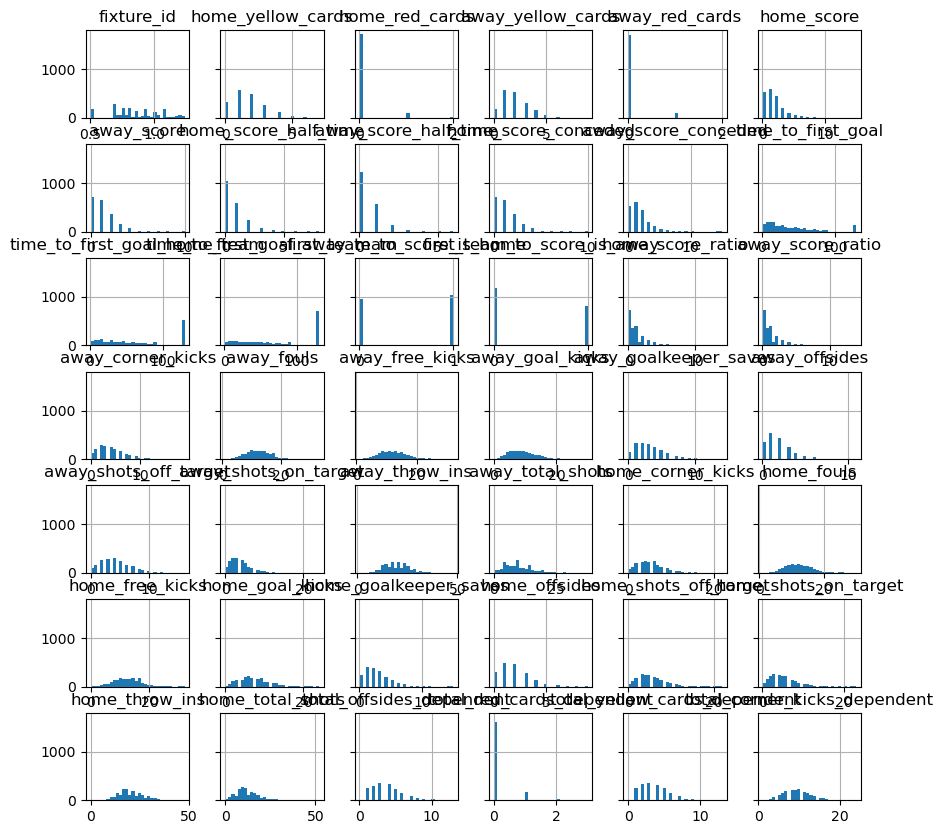

In [79]:
# Frequency tables for each categorical feature
for column in fixtures.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=fixtures[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(fixtures.describe())
%matplotlib inline
hist = fixtures.hist(bins=30, sharey=True, figsize=(10, 10))

## Feature Selection and Data Preparation

To predict Euro 2024 football match outcomes, we simplify our feature selection process by focusing on a subset of key features. This approach prepares our dataset for training our machine learning model effectively.

### Feature Selection:

For simplicity, we focus on the following features:

- _current_match_score_: The score of the current match.
- _participant_: The team participating in the match.
- _is_home_: Boolean indicating if the team is playing at home.
- _opponent_: The opposing team in the match.
- _last_game_is_home_: Boolean indicating if the team's last game was played at home.
- _last_game_score_: The score of the team's last game

In [80]:
fixtures = fixtures.sort_values(by='start_date', ascending=False)

In [92]:
df = fixtures.copy()
# Initialize new columns
df['participant'] = None
df['is_home'] = None
df['opponent'] = None
df['last_game_is_home'] = None
df['last_game_score'] = None
df['current_match_score'] = None

# Helper function to get the last game stats
def get_last_game_stats(team, current_index, df):
    last_game = df[(df['home_articipant'] == team) | (df['away_articipant'] == team)].iloc[:current_index]
    if last_game.empty:
        return None, None
    last_game = last_game.iloc[-1]
    last_game_is_home = last_game['home_articipant'] == team
    last_game_score = last_game['home_score'] if last_game_is_home else last_game['away_score']
    return last_game_is_home, last_game_score

# Feature Engineering
# Feature Engineering
rows = []
for i in range(len(df)):
    row = df.iloc[i]
    home_team = row['home_articipant']
    away_team = row['away_articipant']
    
    # Add home team data
    home_row = row.copy()
    home_row['participant'] = home_team
    home_row['is_home'] = 1
    home_row['opponent'] = away_team
    last_game_is_home, last_game_score = get_last_game_stats(home_team, i, df)
    home_row['last_game_is_home'] = last_game_is_home
    home_row['last_game_score'] = last_game_score
    home_row['current_match_score'] = row['home_score']
    rows.append(home_row)

    # Add away team data
    away_row = row.copy()
    away_row['participant'] = away_team
    away_row['is_home'] = 0
    away_row['opponent'] = home_team
    last_game_is_home, last_game_score = get_last_game_stats(away_team, i, df)
    away_row['last_game_is_home'] = last_game_is_home
    away_row['last_game_score'] = last_game_score
    away_row['current_match_score'] = row['away_score']
    rows.append(away_row)

# Create the new dataframe with all rows
new_df = pd.DataFrame(rows)

# Drop rows with missing values (if any)
new_df.dropna(inplace=True)

# Prepare features and target variable
numerical_features = ['current_match_score','is_home', 'last_game_is_home', 'last_game_score']
categorial_features = ['participant','opponent']
features = categorial_features + numerical_features
new_df[numerical_features] = new_df[numerical_features].astype("int")
new_df[categorial_features] = new_df[categorial_features].astype("category")
new_df = new_df[features]

In [93]:
new_df.columns

Index(['participant', 'opponent', 'current_match_score', 'is_home',
       'last_game_is_home', 'last_game_score'],
      dtype='object')

In [94]:
new_df.head()

,participant,opponent,current_match_score,is_home,last_game_is_home,last_game_score
1989,Austria,Turkey,1,1,1,1
1989,Turkey,Austria,2,0,0,2
1988,France,Belgium,1,1,1,1
1988,Belgium,France,0,0,0,0
1986,Spain,Georgia,4,1,1,3


Next let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the model's accuracy on data it hasn't already seen.

In [95]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Now we'll upload these files to S3.

In [96]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

## Model Training
In this section, we'll train the XGBoost model using SageMaker. First we'll need to specify the locations of the XGBoost algorithm containers.


In [97]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")
display(container)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:1.7-1'

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

In [98]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [99]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="reg:linear",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})



INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-07-04-10-00-30-417


2024-07-04 10:00:30 Starting - Starting the training job...
2024-07-04 10:00:54 Starting - Preparing the instances for training...
2024-07-04 10:01:25 Downloading - Downloading input data...
2024-07-04 10:02:00 Downloading - Downloading the training image.........
2024-07-04 10:03:21 Training - Training image download completed. Training in progress.
2024-07-04 10:03:21 Uploading - Uploading generated training model[2024-07-04 10:03:15.165 ip-10-0-193-2.eu-west-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-07-04 10:03:15.190 ip-10-0-193-2.eu-west-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-07-04:10:03:15:INFO] Imported framework sagemaker_xgboost_container.training
[2024-07-04:10:03:15:INFO] Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
[2024-07-04:10:03:15:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-04:10:03:15:INFO] Running XGBoost Sagema

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between numerous shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyper-parameters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

## Deployment
In this section, we'll deploy the model using SageMaker and create an endpoint for predictions.

---
## Host



In [ ]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-07-04-10-04-12-772
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-07-04-10-04-12-772
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-07-04-10-04-12-772


-

## Model Evaluation
In this section, we'll evaluate the model performance using various metrics.

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making a `http` POST request.  But first, we'll need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [52]:
# calculate MAE or perform other evaluations
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import cross_val_score

mae_train = mean_absolute_error(actual_values_train, predictions_train)
mae_test = mean_absolute_error(actual_values_test, predictions_test)

print(f'Mean Absolute Error (Train): {mae_train}')
print(f'Mean Absolute Error (Test): {mae_test}')

Mean Absolute Error (Train): 0.8213524182513713
Mean Absolute Error (Test): 0.8892435329472459


In [25]:
def predict(data):
    # Assuming xgb_predictor.predict can handle the entire data at once
    predictions = xgb_predictor.predict(data).decode("utf-8")
    return predictions.split("\n")[:-1]

# Predict on train data
predictions_train = predict(train_data.to_numpy()[:, 1:])
predictions_train = np.array(list(map(float, predictions_train)))
actual_values_train = train_data.to_numpy()[:, 0]

# Predict on test data
predictions_test = predict(test_data.to_numpy()[:, 1:])
predictions_test = np.array(list(map(float, predictions_test)))
actual_values_test = test_data.to_numpy()[:, 0]

predict score as int

In [27]:
predictions_test[-1]

1.8388090133666992

In [28]:
test_data.current_match_score.iloc[-1]

2

In [29]:
def create_prediction_vector(columns, team_name, opponent_team, is_home, last_game_score, last_game_home):
    vector=[]
    for col in columns[1:]:
        #print(col)
        if col == 'is_home':
            vector.append(is_home)    
        elif col == 'last_game_is_home_True':
            vector.append(last_game_home)
        elif col == 'last_game_score':
            vector.append(last_game_score)
        elif col == 'participant_'+team_name:
            vector.append(1)
        elif col == 'opponent_'+team_name:
            vector.append(1)
        else:
            vector.append(0)
    return vector


In [30]:
feature_vector = create_prediction_vector(train_data.columns, "Switzerland", "Uzbekistan", 1, 1, 0)
predict(np.array(feature_vector))

['1.291433334350586']

In [31]:
feature_vector = create_prediction_vector(train_data.columns, "Andorra", "Tunisia", 1, 1, 0)
predict(np.array(feature_vector))

['1.597352147102356']


(Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.



In [32]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-07-04-08-31-52-189
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-07-04-08-31-52-189


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)
